In [678]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [679]:
def matprint(mat, fmt="g"):
    """
    Pour une un print plus clair de la matrice
    https://gist.github.com/braingineer/d801735dac07ff3ac4d746e1f218ab75
    """
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

Créons des données synthétiques gaussiennes. Ici nous nous intéresserons dans un premier temps au cas où $m=2$. (Binary MTL Supervised Principal Component Analysis) 

# Algorithme non distribué 2 taches 2 classes
Fonctions pour générer des données synthétiques gaussiennes

In [680]:
def mean_random_matrix(m, k, p, l, h, random_seed=42):
    """
    Retourne une matrice M de taille pxm*k contenant
    les moyennes de chaque composante de chaque vecteur aléatoire
    pour l'instant les moyennes sont tirées aléatoirement 
    suivant la loi uniforme sur l, h (pas convaincu par ce choix)
    m est le nombre de classes
    k est le nombre de taches
    p est le nombre de features
    """
    np.random.seed(random_seed)
    M = []
    tmp = []
    for task in range(k):
        tmp = []
        for classe in range(m):
            # on crée un vecteur de moyennes égales pour chaque classes
            # de sorte à créer des classes gravitant autour d'une meme moyenne
            tmp.append(np.ones((p,1))*np.random.uniform(low = 0.0, high = h))
        M.append(tmp)
    return M

Si on prend des moyennes de la même façon que dans le papier

In [714]:
beta = 0.00001
np.random.seed(42)
#mu_1 = np.ones((p,1))*np.random.uniform(low = 0.0, high = 10.)
mu_1 = np.zeros((p,1))
mu_1[0]= 1
perpendicular_vector = np.zeros((p,1))
perpendicular_vector[-1] = 1
#for i in range(0,p-1,2):
#    perpendicular_vector[i] = 1
#    perpendicular_vector[i+1] = -1
#matprint(np.transpose(mu_1).dot(perpendicular_vector))
mu_2 = beta*mu_1+np.sqrt(1-beta**2)*perpendicular_vector
M = [[mu_1, -mu_1], [mu_2, -mu_2]]
#print(M)

In [715]:
# Test
# ici on reprend les mêmes paramètres que dans la figure 2
n_t = [[1000,1000], [50,50]]
n = 2200
p = 100
m = 2
t = 2
# 2 taches, 2 classes, p = 20
#M = mean_random_matrix(m, t, p, 0., 20.)
#print(M)

# pour plusieurs taches
# M = mean_matrix(2, 3, 10, 0., 2.)
# print(M)

In [716]:
def gaussian_synthetic_data(n, p, m, t, n_t, M):
    """
    Renvoie un tableau de données synthétiques gaussiennes. X[0] accède aux données de la premiere tache.
    X[0][1] accede aux données de la deuxieme classe de la premiere tache.
    (vecteurs gaussiens de taille n_j * p tq sum(n_j for j) = n)
    à partir du nombre d'échantillons n de taille p et du nombre de classe m.
    t est le nombre de tâches
    n_t est un vecteur comprenant les différentes valeurs n_j pour chaque task
    M est la matrice des moyennes de chaque composante 
    de chaque vecteur aléatoire
    """
    # assert(sum(n_j)/n==1
    np.random.seed(55)
    X = []
    tmp = []
    for task in range(t):
        # pour une tache on a m classes
        tmp = []
        for k in range(m):
            X_k = np.empty((n_t[task][k], p))
            # on prendra la transposée a la fin
            #print( n_t[task][k])
            for j in range(n_t[task][k]):
                # on crée n_j[task][k] vecteurs aléatoires de taille 1xp
                # std = 1?
                X_k[j] = np.random.normal(M[task][k][0], 1, size=(1, p))
                # indice 0 parce que c'est toujours la meme moyenne dans M (pour l'instant ?)
            X_k = np.transpose(X_k)
            #print(k)
            tmp.append(X_k)
            # print("tmp = ", tmp)
        X.append(tmp)
            
    return X

In [717]:
X = gaussian_synthetic_data(n, p, m, t, n_t, M)

In [718]:
def train_test_split_data(X, split_rate, nb_tasks, nb_classes):
    """
    Retourne une matrice de données de tests, et une matrice d'entrainement
    """
    X_train = []
    X_test = []
    tmp_test = []
    tmp_train = []
    n_t_train = []
    n_t_test = []
    for t in range(nb_tasks):
        tmp_test = []
        tmp_train = []
        tmp_nt_train = []
        tmp_nt_test = []
        for l in range(nb_classes):
            decoupe = int(split_rate*X[t][l].shape[1])
            tmp_train.append(X[t][l][:, :decoupe])
            tmp_test.append(X[t][l][:, decoupe:])
            tmp_nt_train.append(decoupe)
            tmp_nt_test.append(X[t][l].shape[1]-decoupe)
        n_t_train.append(tmp_nt_train)
        n_t_test.append(tmp_nt_test)
        X_train.append(tmp_train)
        X_test.append(tmp_test)
    return X_train, X_test, n_t_train, n_t_test

In [719]:
X_train, X_test, n_t_train, n_t_test = train_test_split_data(X, 0.8, 2, 2)
n_t_train
X_test[0][0].shape

(100, 200)

Il faut aussi créer le vecteur $\tilde{y}\in\mathbb{R}^{2k}$, qui contiendra les labels associées aux données.

In [720]:
def create_labels(nb_tasks, nb_classes):
    """
    Crée le vecteurs y_tilde contenant les labels associés aux données.
    Ici on le fait pour deux 2 tâches et pour deux classes.
    """
    y = np.empty((nb_classes*nb_tasks))
    for t in range(0, nb_classes*nb_tasks-1, 2):
        y[t] = -1
        y[t+1] = 1
        
    return y

In [721]:
y = create_labels(2,2)
print(y)

[-1.  1. -1.  1.]


## 1ère etape
Calcul des moyennes empiriques, et calcul de la matrice $M\in\mathbb{R}^{p\times 2k}$

In [722]:
# pas fait le cas du j=j' mais j'ai pas l'impression que c'est nécessaire en tout cas pas ici ?

def empirical_mean(nb_tasks, nb_classes, X, p, n_t):
    """
    compute empirical mean for data X
    return an 1xp vector being the empirical mean for the random vector X_{tj}
    retourne la matrice M
    """
    M = np.empty((nb_classes*nb_tasks, p))
    for t in range(nb_tasks):
        for l in range(nb_classes):
            #print(X[t][l].dot(np.ones((n_t[t][l]))).shape)
            # print(t*nb_classes+l)
            M[t*nb_classes+l] = X[t][l].dot(np.ones((n_t[t][l])))
            M[t*nb_classes+l] /= n_t[t][l]
            print(f"class {t*nb_classes+l} empirical mean = {np.mean(M[t*nb_classes+l])}")
    return np.transpose(M)

In [723]:
M_mean = empirical_mean(2, 2, X_train, p, n_t_train)
#matprint(M_mean)
#print(M)

class 0 empirical mean = 1.0016854475198598
class 1 empirical mean = -1.0024964646763792
class 2 empirical mean = 0.017171233864806727
class 3 empirical mean = -0.005212844666448196


In [724]:
# utile pour les puissances négatives
def power_diagonal_matrix(D, exponent):
    diag = np.zeros(len(D))
    for i in range(len(D)):
        diag[i] = D[i][i]**exponent
    
    return np.diag(diag)

## 2ème étape
Estimer $c$ et $\mathcal{M}\in\mathbb{R}^{2k\times 2k}$. 
$c=\left[ c_{11},\ldots,c_{km} \right]^T\in\mathbb{R}^{km}$

In [725]:
def estimate_c(n_t, n, nb_tasks, nb_classes):
    c = np.empty(nb_tasks*nb_classes)
    for task in range(nb_tasks):
        for m in range(nb_classes):
            c[task*nb_classes+m]=n_t[task][m]/n
            
    return c

In [726]:
c = estimate_c(n_t, n, t, m)
print(f"c = {c}T")
Dc = np.diag(c)
Dc

c = [0.45454545 0.45454545 0.02272727 0.02272727]T


array([[0.45454545, 0.        , 0.        , 0.        ],
       [0.        , 0.45454545, 0.        , 0.        ],
       [0.        , 0.        , 0.02272727, 0.        ],
       [0.        , 0.        , 0.        , 0.02272727]])

In [727]:
def compute_M_cal(n,p,Dc,M):
    """
    renvoie la matrice M cursive estimée
    """
    c0 = p/n
    return 1/c0*np.power(Dc, 1/2).dot(np.transpose(M)).dot(M).dot(np.power(Dc, 1/2))

 1004.39  -1004.17   3.85776  -1.12221  
-1004.17   1006.36  -3.71606   1.15318  
 3.85776  -3.71606   1.25373  0.101312  
-1.12221   1.15318  0.101312   1.25283  


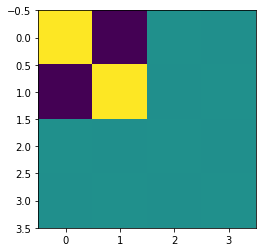

In [728]:
correlation_matrix = compute_M_cal(n,p,Dc,M_mean)
matprint(correlation_matrix)
plt.imshow(correlation_matrix)
plt.show()

Cette cmap est bizarre, mais peut-être que c'est bon je sais pas.

## 3ème étape
Let's compute optimal labels

In [729]:
# a revoir

def label_evaluation(nb_tasks, nb_classes, Dc, M_estimated):
    """
    Evalue le label y pour une tache t et une classe l donnée
    Comme ca qu'il faut écrire e_t1 ?
    """
    inverse = np.linalg.inv(M_estimated+np.identity(nb_classes*nb_tasks))
    power_dc = power_diagonal_matrix(Dc, -1/2)
    et1_et2 = np.zeros((nb_tasks*nb_classes,1))
    et1_et2[0] = 1
    et1_et2[1] = -1
    matprint(et1_et2)
    y_1 = power_dc.dot(inverse).dot(M_estimated).dot(power_dc).dot(et1_et2)
    et1_et2 = np.zeros((nb_tasks*nb_classes,1))
    et1_et2[2] = 1
    et1_et2[3] = -1
    matprint(et1_et2)
    y_2 = power_dc.dot(inverse).dot(M_estimated).dot(power_dc).dot(et1_et2)
    y = np.empty((nb_tasks*nb_classes, 1))
    y[0] = y_1[0]
    y[1] = y_1[1]
    y[2] = y_2[2]
    y[3] = y_2[3]
    return y

In [730]:
y = label_evaluation(t,m,Dc,correlation_matrix)
print("optimal labels for a 2-task 2-class example with synthetic gaussian data : ")
matprint(y)
y.shape

 1  
-1  
 0  
 0  
 0  
 0  
 1  
-1  
optimal labels for a 2-task 2-class example with synthetic gaussian data : 
 2.19829  
 -2.1995  
 23.3505  
-23.4965  


(4, 1)

## 4ème étape
Estimation des $m_{tj}$, étant les $k\times m$ moyennes estimées pour modéliser nos données.

In [731]:
def asymptotic_mean(nb_tasks, nb_classes, y_tilde, Dc, correlation_matrix, t, j):
    """
    compute asymptotic mean m_tj
    t current task
    j current class
    """
    y_transpose = np.transpose(y_tilde)
    etj = np.zeros((nb_tasks*nb_classes, 1))
    etj[t*nb_classes+j] = 1
    power_dc = power_diagonal_matrix(Dc, -1/2)
    # Dc^1/2 ou Dc^{-1/2} ?
    m_tj = y_transpose.dot(np.power(Dc, 1/2)).dot(correlation_matrix).dot(power_dc).dot(etj)
    m_tj /= np.sqrt(y_transpose.dot(np.power(Dc, 1/2).dot(correlation_matrix).dot(np.power(Dc, 1/2)) + Dc).dot(y_tilde))
    return m_tj[0][0]

In [732]:
for k in range(t):
    for l in range(m):
        print(f"m_kl = {asymptotic_mean(t, m, y, Dc, correlation_matrix, k, l)}")

m_kl = 46.84494847802324
m_kl = -46.884568376432185
m_kl = 1.0689182272786668
m_kl = -0.5213875295029323


Les valeurs ont l'air particulièrement grandes par rapport aux moyennes empiriques trouvées.

## 5ème étape
Calcul de $V$ le sous-espace engendrés par les $\tau$ plus grands vecteurs propres. Dans le cas du binary MTL-SPCA, $V=\frac{Xy}{\lVert Xy \rVert}=\frac{XJ\tilde{y}}{\lVert XJ\tilde{y} \rVert}\in\mathbb{R}^{p\times1}$, avec $J\in\mathbb{R}^{n\times km}$

In [733]:
def aggregate_array(X, p, n, nb_tasks, nb_classes):
    X_aggregated = np.empty((p, n))
    class_1 = X[0][0]
    for t in range(nb_tasks):
        for l in range(nb_classes):
            if t==0 and l==0:
                continue
            class_1 = np.append(class_1, X[t][l], 1)
    X_aggregated = class_1
    return X_aggregated

In [734]:
X_train_aggregated = aggregate_array(X_train, p, n, t, m)
X_test_aggregated = aggregate_array(X_train, p, n, t, m)
print(X_train_aggregated.shape)

(100, 1680)


$V=\frac{Xy}{\lVert Xy \rVert}=\frac{XJ\tilde{y}}{\lVert XJ\tilde{y} \rVert}$

In [735]:
def compute_V(y_tilde, X, J):
    xy_product = X.dot(J).dot(y_tilde)
    return xy_product/np.linalg.norm(xy_product)

In [736]:
def create_J(nb_classes, nb_tasks, n, n_t):
    left = 0
    for i in range(2):
        left += int(sum(n_t[i]))
    J = np.zeros((left, nb_tasks*nb_tasks))
    for t in range(nb_tasks):
            for j in range(nb_classes):
                for i in range((t*nb_classes+j)*n_t[t][j], n_t[t][j]+(t*nb_classes+j)*n_t[t][j]):
                    J[i][t*nb_classes+j] = 1
    return J

In [737]:
J = create_J(m, t, n, n_t_train)
#matprint(J)
#x = np.random.normal(0, 1, size=(p,1))
#compute_score(y, J, X, x)

In [738]:
V = compute_V(y, X_train_aggregated, J)
V.shape

(100, 1)

## 6ème étape
Evaluation de nouvelles données $\mathbf{x}$ : 
$V^T\mathbf{x}$

On utilise les données du test set $X\_test$. On obtient de très mauvais résultats

In [739]:
m_t = []
for k in range(t):
    m_tj = []
    for l in range(m):
        m_tj.append(asymptotic_mean(t, m, y, Dc, correlation_matrix, k, l))
    m_t.append(m_tj)

print(m_t)

[[46.84494847802324, -46.884568376432185], [1.0689182272786668, -0.5213875295029323]]


In [740]:
def compute_score(V, x, m_t):
    """
    x vecteur aléatoire que l'on veut classifier
    On compare V^Tx à la moyenne des moyennes estimées pour les deux classes de la tache t
    """
    x_projection = np.transpose(V).dot(x)
    average_mean = 1/2*(m_t[0] + m_t[1])
    return (1 if x_projection > average_mean else -1) 

In [741]:
def plot_error_rate(X_test, m_t, nb_tasks, nb_classes, n_t):
    """
    Compute and plot classification error rate on test set
    """
    error_rate = []
    for t in range(nb_tasks):
        for l in range(nb_classes):
            n = n_t[t][l]
            error = 0
            for i in range(n):
                # on prend la transposée pour pouvoir travailler avec les colonnes
                score = compute_score(V, np.transpose(X_test[t][l])[i], m_t[t])
                #print(score)
                error += 1 if (score == 1 and l == 1) else 0
            error_rate.append(error/n)
    
    plt.scatter(range(4), error_rate)
    plt.grid()
    plt.title("Classification error rate per task per class")

    return error_rate

[0.0, 0.0, 0.0, 0.4]

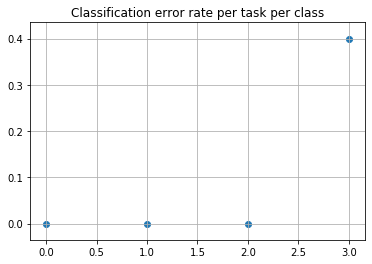

In [742]:
plot_error_rate(X_test, m_t, t, m, n_t_test)

In [746]:
from scipy import special as sp
def qfunc(x):
    return 0.5-0.5*sp.erf(x/np.sqrt(2))

In [747]:
def error_rate(m_t):
    return qfunc(1/2*(m_t[0] - m_t[1]))

In [748]:
error_rate(m_t[1])

0.213262289250243

# Algorithme distribué 2 tâches 2 classes
Bien que certains résultats du précedent algorithmes sont particulèrement inquiétants, essayons de voir comment distribuer l'algorithme sur plusieurs serveurs.

Par exemple un serveur demande les moyennes des autres serveurs pour pouvoir obtenir des meilleurs résultats en calculant la moyenne des ses données et la moyenne de toutes les moyennes avant de le renvoyer au serveur principal qui mettra à jour le modèle.

Prendre des données synthétiques pour la 1ère tâche à 2 classes, puis rappatrier une ou plusieurs moyennes pour les autres tasks. 
Faire des comparaisons, avec et sans federated learning.